Code for instance generation

In [13]:
import gurobipy as gp
import numpy as np
from typing import Dict, Tuple
from time import time_ns
import time
import pandas as pd
from pathlib import Path
import numpy as np
import json

INTERVAL_SIZE = 5  # minutes, window is 4:00–6:00 PM (120 mins total -> 24 intervals)

EXP_RIDERSHIP = {
    'Lakeshore West': 33239,
    'Lakeshore East': 25769,
    'Kitchener': 15071,
    'Milton': 13138,
    'Barrie': 8636,
    'Stouffville': 7341,
    'Richmond Hill': 4642
}

def time_labels(interval_size):
    labels = []
    for t in range(0, 120, interval_size):
        hour = 4 + (t // 60)
        minute = t % 60
        labels.append(f"{hour}:{minute:02d}")
    return labels

def gaussian_curve(num_points, peak_idx, width_pts):
    x = np.arange(num_points)
    curve = np.exp(-0.5 * ((x - peak_idx) / max(width_pts, 1e-6))**2)
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def beta_curve(num_points, a, b):
    x = np.linspace(0, 1, num_points)
    a = max(a, 0.1); b = max(b, 0.1)
    curve = (x**(a-1)) * ((1-x)**(b-1))
    curve[np.isnan(curve)] = 0
    s = curve.sum()
    if s == 0:
        curve = np.ones(num_points)
        s = curve.sum()
    return curve / s

def build_curve(shape, interval_size, peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0):
    num_points = 120 // interval_size
    if shape == "gaussian":
        peak_idx = int(round(peak_time_min / interval_size))
        width_pts = max(1, int(round(peak_width_min / interval_size)))
        return gaussian_curve(num_points, peak_idx, width_pts)
    elif shape == "beta":
        return beta_curve(num_points, beta_a, beta_b)
    else:
        raise ValueError("shape must be 'gaussian' or 'beta'")

# ---------------------------
# CORE GENERATION (simplified like the  original)
# ---------------------------

def generate_scenario(seed=None, interval_size=INTERVAL_SIZE, global_scale=1.0, spread=0.10,
                      shape="gaussian", peak_time_min=75, peak_width_min=24, beta_a=3.0, beta_b=3.0,
                      line_scales=None):
    if seed is None:
        seed = time_ns()
    if not isinstance(seed, int):
        seed = sum(ord(c) for c in str(seed))
    np.random.seed(seed % (2**32 - 1))

    #generating random set of parameters
    rng = np.random.default_rng()
    global_scale = rng.uniform(0.5,1.0)
    spread = rng.uniform(0.05,0.30)
    peak_time_min = rng.integers(low=30, high=80)
    peak_width_min = rng.integers(low=10, high = 50)


    if line_scales is None:
        line_scales = {}

    labels = time_labels(interval_size)
    curve = build_curve(shape, interval_size, peak_time_min, peak_width_min, beta_a, beta_b)

    scenario = {}
    for line in EXP_RIDERSHIP:
        scenario[line] = {}

    for line, base_total in EXP_RIDERSHIP.items():
        lscale = line_scales.get(line, 1.0)
        target_total = base_total * global_scale * lscale

        mean_per_bucket = target_total * curve
        noise_std = np.maximum(1e-9, spread * mean_per_bucket)
        noisy = np.maximum(0.0, np.random.normal(loc=mean_per_bucket, scale=noise_std))

        s = noisy.sum()
        if s > 0:
            adjusted = noisy * (target_total / s)
        else:
            adjusted = np.ones_like(noisy) * (target_total / len(noisy))

        ints = np.floor(adjusted).astype(int)
        remainder = int(round(target_total - ints.sum()))
        if remainder > 0:
            # add to buckets with largest fractional parts
            remainders = (adjusted - ints).argsort()[::-1][:remainder]
            ints[remainders] += 1
        elif remainder < 0:
            # subtract from buckets with largest overshoot
            remainders = (ints - adjusted).argsort()[::-1][:(-remainder)]
            ints[remainders] -= 1

        for i, tlabel in enumerate(labels):
            scenario[line][tlabel] = int(max(0, ints[i]))

    return scenario

Code for visualizing instance

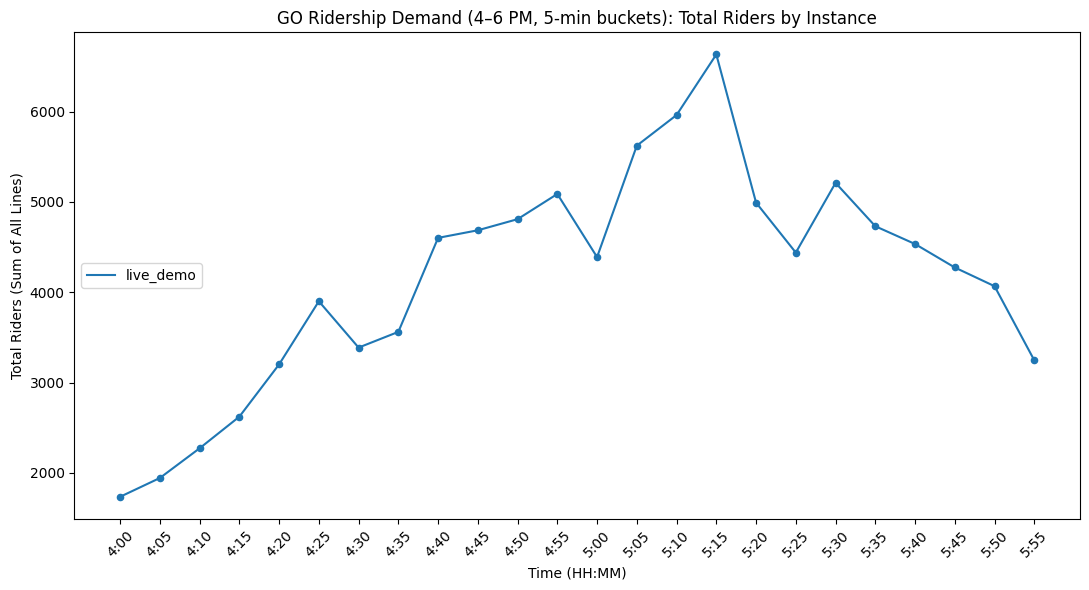

Total demand: 99907


In [14]:
from matplotlib import pyplot as plt

instances = {'live_demo': generate_scenario()}

#Plotting demand

# Get time axis from any scenario (they share labels)
any_scen = next(iter(instances.values()))
time_axis = list(next(iter(any_scen.values())).keys())

# Sum across lines per time for each instance
def totals_over_time(scen):
    return [sum(scen[line][t] for line in scen) for t in time_axis]

plt.figure(figsize=(11, 6))
for name, scen in instances.items():
    plt.plot(time_axis, totals_over_time(scen), label=name)
    plt.scatter(time_axis, totals_over_time(scen), s=20)

plt.title("GO Ridership Demand (4–6 PM, 5-min buckets): Total Riders by Instance")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Total Riders (Sum of All Lines)")
plt.xticks(rotation=45)
plt.legend(loc="center left")
plt.tight_layout()
plt.show()

tot_demand = 0

for name, scen in instances.items():
    tot_demand = sum(totals_over_time(scen))

print(f"Total demand: {tot_demand}")

Solve with MIP

In [15]:
scenarios = ['live_demo']
results = []
for day in scenarios:
    print(f"\n--------- {day} -----------")
    data = instances[day]

    line_map = {
        'Lakeshore West': 1,
        'Lakeshore East': 2,
        'Kitchener': 3,
        'Milton': 4,
        'Barrie': 5,
        'Stouffville': 6,
        'Richmond Hill': 7
    }

    time_map = {time: i + 1 for i, time in enumerate(data['Lakeshore West'].keys())}

    D = {}
    for line_name, time_dict in data.items():
        l = line_map[line_name]
        for time, d in time_dict.items():
            t = time_map[time]
            D[(l, t)] = d
            

    m = gp.Model()
    m.Params.outputFlag = 1
    m.Params.TimeLimit = 10 #for sake of presentation time

    lines = range(1, 8)
    platforms = range(1, 15)
    times = range(1, 25)

    x = m.addVars(lines, platforms, times, vtype=gp.GRB.INTEGER, lb=0, name="x")
    p = m.addVars(lines, platforms, times, vtype=gp.GRB.INTEGER, lb=0, name="p")
    y = m.addVars(lines, platforms, times, vtype=gp.GRB.BINARY, name="y")
    u = m.addVars(lines, times, vtype=gp.GRB.INTEGER, lb=0, name="u")

    m.setObjective(
        gp.quicksum(u[l, t] for l in lines for t in times),
        gp.GRB.MINIMIZE
    )
    m.addConstrs((u[l, 1] >= D.get((l, 1), 0) - gp.quicksum(p[l, tr, 1] for tr in platforms)
                  for l in lines), name="Starting Demand")

    m.addConstrs((u[l, t] >= D.get((l, t), 0) - gp.quicksum(p[l, tr, t] for tr in platforms) + u[l, t-1]
                  for l in lines 
                  for t in range(2, 25)), name="Demand Satisfaction")

    m.addConstrs((p[l, tr, t] <= 162 * x[l, tr, t] 
                  for l in lines 
                  for tr in platforms 
                  for t in times), name="Passenger Capacity")

    m.addConstrs((gp.quicksum(y[l, tr, t] for l in lines for tr in platforms) <= 14 
                  for t in times), name="Platform Usage")

    m.addConstrs((gp.quicksum(y[l, tr, t] for l in lines) <= 1
                  for tr in platforms
                  for t in times), name="Platform difference")

    m.addConstrs((x[l, tr, t] <= 12 * y[l, tr, t] 
                  for l in lines 
                  for tr in platforms 
                  for t in times), name="Platform Coach Link")

    m.addConstr( gp.quicksum(y[l, tr, t] for l in lines for tr in platforms for t in times) <= 80, name="Train Formation")

    m.addConstr(gp.quicksum(x[l, tr, t] for l in lines for tr in platforms for t in times) <= 756, name="Total Coach")


    m.optimize()
    
    coaches = sum(x[l, tr, t].x for l in lines for tr in platforms for t in times)


    print("Model Runtime:",m.runtime)
    print("Model Obj:",m.ObjVal)
    print("Total Coaches Used:", coaches)
    
    results.append({
        "Scenario": day,
        "Runtime (s)": m.Runtime,
        "Objective Value": m.ObjVal,
        "Total Coaches Used": coaches
    })
    
results_df = pd.DataFrame(results)

print(results_df)


--------- live_demo -----------
Set parameter OutputFlag to value 1
Set parameter TimeLimit to value 10
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  10

Optimize a model with 5234 rows, 7224 columns and 21497 nonzeros
Model fingerprint: 0x02bc7752
Variable types: 0 continuous, 7224 integer (2352 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Found heuristic solution: objective 1130496.0000
Presolve removed 2418 rows and 2394 columns
Presolve time: 0.06s
Presolved: 2816 rows, 4830 columns, 14357 nonzeros
Variable types: 0 continuous, 4830 integer (2355 binary)

Root relaxation: objective 0.000000e+00, 560 iterations, 0.00 seconds (0.00 

Solve with Dispatch

In [16]:
import math
import pandas as pd
import numpy as np

all_profiles = [
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday",
    "Saturday", "Sunday", "Christmas", "CNE", "Valentines"
]

# LINE SHORT NAMES
line_map = {
    'Lakeshore West': 'LW',
    'Lakeshore East': 'LE',
    'Kitchener': 'K',
    'Milton': 'M',
    'Barrie': 'B',
    'Stouffville': 'S',
    'Richmond Hill': 'RH'
}

# Constants
S = 162        # Seats per coach
Cmax = 12      # Max coaches per train
P = 14         # Platforms per time slot


import time
import psutil
import pandas as pd

def standard_dispatch(scenario, profile_name=""):
    print(f"\n=== Dispatch Schedule for {profile_name} ===")

    line_map = {
        'Lakeshore West': 'LW',
        'Lakeshore East': 'LE',
        'Kitchener': 'K',
        'Milton': 'M',
        'Barrie': 'B',
        'Stouffville': 'S',
        'Richmond Hill': 'RH'
    }

    # Rename lines
    demand = {line_map[line]: scenario[line] for line in scenario}
    lines = list(demand.keys())
    time_intervals = list(next(iter(demand.values())).keys())

    # Initialize resources
    Lmax = 80
    Ctotal = 756
    schedule = []
    unmet_cumulative = {l: 0 for l in lines}
    DISPATCH=True
    obj=0
    # Dispatch Loop: Assign resources based on demand for each time slot
    for t_idx, t in enumerate(time_intervals):
        trains_scheduled = 0

        for l in lines:
            if Lmax <= 0 or Ctotal <= 0 or trains_scheduled >= P:
                DISPATCH=False


            Dl_t = demand[l][t]+unmet_cumulative[l]
            unmet=0


            # Standard Dispatch Rule: Always try to dispatch based on the demand
            if Dl_t > 0 and DISPATCH!=False:  # If there's any demand, dispatch coaches
                Cl_t = min(Cmax, math.ceil(Dl_t / S))  # Calculate coaches needed
                if Ctotal < Cl_t:
                    Cl_t = Ctotal  # Limit to available coaches
                    seated = Cl_t*S
                    obj+=Dl_t-seated
                elif Cl_t==Cmax:seated = Cmax*S
                else:
                  seated = Dl_t

                obj+=Dl_t-seated
                if Cl_t == 0:
                    continue

                unmet = demand[l][t] - seated  # Recalculate unmet demand after dispatch

                # Decrease available resources
                Ctotal -= Cl_t
                Lmax -= 1
                trains_scheduled += 1
                unmet_cumulative[l] = unmet_cumulative[l]+unmet
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Demand': demand[l][t],
                    'Coaches Assigned': Cl_t,
                    'Passengers Seated': seated,
                    'Unmet Demand': unmet,
                    'unmet_cumu': unmet_cumulative[l],  # Track the cumulative unmet demand
                    'Objective Value': obj,  # Objective value is the cumulative unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })
            else:
                # If no dispatch happens, log the demand
                #unmet = max(0, Dl_t - unmet_cumulative.get(l, 0))
                unmet=demand[l][t]
                unmet_cumulative[l] += unmet
                obj+=unmet_cumulative[l]
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Demand': demand[l][t],
                    'Coaches Assigned': 0,
                    'Passengers Seated': 0,
                    'Unmet Demand': Dl_t,  # All demand is unmet in this case
                    'unmet_cumu': unmet_cumulative[l],  # Track the cumulative unmet demand
                    'Objective Value': obj,  # Objective value is the cumulative unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })

    # Create DataFrame and sort by Time and Line
    df_schedule = pd.DataFrame(schedule)
    df_schedule = df_schedule[['Time', 'Line', 'Demand', 'Coaches Assigned', 'Passengers Seated',
                               'Unmet Demand', 'unmet_cumu','Objective Value', 'Remaining Coaches', 'Remaining Locomotives']]
    df_schedule.sort_values(by=['Time', 'Line'], inplace=True)

    return df_schedule

def heuristic_dispatch2(scenario, profile_name=""):
    print(f"\n=== Dispatch Schedule for {profile_name} ===")
    line_map = {
        'Lakeshore West': 'LW',
        'Lakeshore East': 'LE',
        'Kitchener': 'K',
        'Milton': 'M',
        'Barrie': 'B',
        'Stouffville': 'S',
        'Richmond Hill': 'RH'
    }

    # Rename lines
    demand = {line_map[line]: scenario[line] for line in scenario}
    lines = list(demand.keys())
    time_intervals = list(next(iter(demand.values())).keys())

    # Initialize resources
    Lmax = 80
    Ctotal = 756
    unmet_cumulative = {l: 0 for l in lines}
    schedule = []
    obj=0
    # Dispatch Loop
    for t_idx, t in enumerate(time_intervals):
        trains_scheduled = 0
        sorted_lines = sorted(lines, key=lambda l: (-demand[l][t], -unmet_cumulative[l]))

        for l in sorted_lines:
            unmet=0
            Dl_t = demand[l][t]+unmet_cumulative[l]
            dispatch_now = False
            if Dl_t / S >= 3:
                dispatch_now = True
            if Lmax <= 0 or Ctotal <= 0 or trains_scheduled >= P:
                dispatch_now = False



            if dispatch_now:
                # Calculate the number of coaches to assign
                Cl_t = min(Cmax, math.ceil(Dl_t / S))
                if Ctotal < Cl_t:
                    Cl_t = Ctotal
                    seated=Ctotal*S
                    obj+=Dl_t-seated
                elif Cl_t == Cmax:
                    seated=Cmax*S
                    obj+=unmet_cumulative[l]
                else:
                    seated=Dl_t

                if Cl_t == 0:
                    continue
                unmet = demand[l][t] - seated  # Recalculate unmet demand after dispatch

                Ctotal -= Cl_t
                Lmax -= 1
                trains_scheduled += 1
                unmet_cumulative[l] = unmet_cumulative[l]+unmet
                # If demand >= 3 coaches → dispatch now
                # Log the unmet demand (for the objective value calculation)

                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Demand':demand[l][t],
                    'Coaches Assigned': Cl_t,
                    'Passengers Seated': seated,
                    'Unmet Demand': unmet,
                    'unmet_cumu': unmet_cumulative[l],
                    'Objective Value': obj,  # Objective value is the cumulative unmet demand
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })
            else:
                seated=0
                # If dispatch_now is False, log the necessary info
                unmet=demand[l][t]
                obj+=Dl_t
                unmet_cumulative[l] += unmet  # Keep adding to the cumulative unmet demand
                # If demand >= 3 coaches → dispatch now
                # Log the unmet demand (for the objective value calculation)
                schedule.append({
                    'Time': t,
                    'Line': l,
                    'Demand':demand[l][t],
                    'Coaches Assigned': 0,  # No coaches assigned
                    'Passengers Seated': 0,  # No passengers seated
                    'Unmet Demand': unmet,
                    'unmet_cumu': unmet_cumulative[l],  # Track the cumulative unmet demand
                    'Objective Value': obj,
                    'Remaining Coaches': Ctotal,
                    'Remaining Locomotives': Lmax
                })

    # Create DataFrame and sort by Time and Line
    df_schedule = pd.DataFrame(schedule)
    df_schedule = df_schedule[['Time', 'Line', 'Demand','Coaches Assigned', 'Passengers Seated',
                               'Unmet Demand', 'unmet_cumu','Objective Value', 'Remaining Coaches', 'Remaining Locomotives']]
    df_schedule.sort_values(by=['Time', 'Line'], inplace=True)

    return df_schedule

def evaluate_scenario_performance(instances, dispatch_method="heuristic"):
    """
    Evaluate performance for each scenario and return a summary of the results.
    Allows choosing between standard dispatch and heuristic dispatch.

    Args:
        profiles (dict): Dictionary of profiles to evaluate.
        dispatch_method (str): The dispatch method to use. Can be 'standard' or 'heuristic'.

    Returns:
        pd.DataFrame: DataFrame containing performance metrics for all scenarios.
    """
    # Ensure valid dispatch method
    if dispatch_method not in ["standard", "heuristic"]:
        raise ValueError("Invalid dispatch method. Choose 'standard' or 'heuristic'.")

    performance_results = []

    # Iterate through all scenarios in PROFILES
    for profile_name, instance in instances.items():
        # Generate the scenario based on profile
        scenario = instance

        # Track computational time and memory consumption
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss  # in bytes

        # Dispatch using the chosen dispatch method
        if dispatch_method == "heuristic":
            df = heuristic_dispatch2(scenario, profile_name=profile_name)
        else:
            df = standard_dispatch(scenario, profile_name=profile_name)

        # End time and memory consumption tracking
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss  # in bytes

        # Calculate elapsed time and memory used
        elapsed_time = end_time - start_time
        memory_used = end_memory - start_memory

        # Get the objective value (sum of unmet demand across all time slots and lines)
        objective_value = df.loc[df["Time"] == "5:55", "Objective Value"].max()

        # Store the results
        performance_results.append({
            'Profile Name': profile_name,
            'Objective Value': objective_value,
            'Computational Time (seconds)': elapsed_time,
            'Memory Consumption (bytes)': memory_used
        })

        # Optionally print the results for the current scenario
        print(f"Scenario: {profile_name}")
        print(f"Objective Value: {objective_value}")
        print(f"Computational Time: {elapsed_time:.4f} seconds")
        print(f"Memory Consumption: {memory_used / (1024 * 1024):.2f} MB\n")

    # Return the performance results as a DataFrame
    performance_df = pd.DataFrame(performance_results)
    return performance_df

# Example of evaluating performance for all scenarios with 'heuristic' dispatch
performance_df_heuristic = evaluate_scenario_performance(instances, dispatch_method="heuristic")

# Example of evaluating performance for all scenarios with 'standard' dispatch
performance_df_standard = evaluate_scenario_performance(instances, dispatch_method="standard")

# Print the performance summary for all scenarios (for heuristic)
print("Heuristic Dispatch Performance:")
print(performance_df_heuristic)

# Print the performance summary for all scenarios (for standard)
print("Standard Dispatch Performance:")
print(performance_df_standard)



=== Dispatch Schedule for live_demo ===
Scenario: live_demo
Objective Value: 113338
Computational Time: 0.0063 seconds
Memory Consumption: 0.03 MB


=== Dispatch Schedule for live_demo ===
Scenario: live_demo
Objective Value: 424518
Computational Time: 0.0049 seconds
Memory Consumption: 0.00 MB

Heuristic Dispatch Performance:
  Profile Name  Objective Value  Computational Time (seconds)  \
0    live_demo           113338                      0.006338   

   Memory Consumption (bytes)  
0                       32768  
Standard Dispatch Performance:
  Profile Name  Objective Value  Computational Time (seconds)  \
0    live_demo           424518                      0.004866   

   Memory Consumption (bytes)  
0                           0  


Gathering results

In [17]:
cumulative_demand = [results[0]["Objective Value"], float(performance_df_heuristic['Objective Value']), float(performance_df_standard['Objective Value'])]

exec_time = [float(performance_df_standard['Computational Time (seconds)']), float(performance_df_heuristic['Computational Time (seconds)']), results[0]['Runtime (s)']]

avg_wait_time = [x/tot_demand*5 for x in cumulative_demand]

cumulative_demand, exec_time, avg_wait_time

/tmp/ipykernel_13345/3154639052.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cumulative_demand = [results[0]["Objective Value"], float(performance_df_heuristic['Objective Value']), float(performance_df_standard['Objective Value'])]
/tmp/ipykernel_13345/3154639052.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  exec_time = [float(performance_df_standard['Computational Time (seconds)']), float(performance_df_heuristic['Computational Time (seconds)']), results[0]['Runtime (s)']]


([38371.0, 113338.0, 424518.0],
 [0.004865884780883789, 0.006338357925415039, 8.996217012405396],
 [1.9203359123985306, 5.672175122864264, 21.245658462370006])

Plotting results

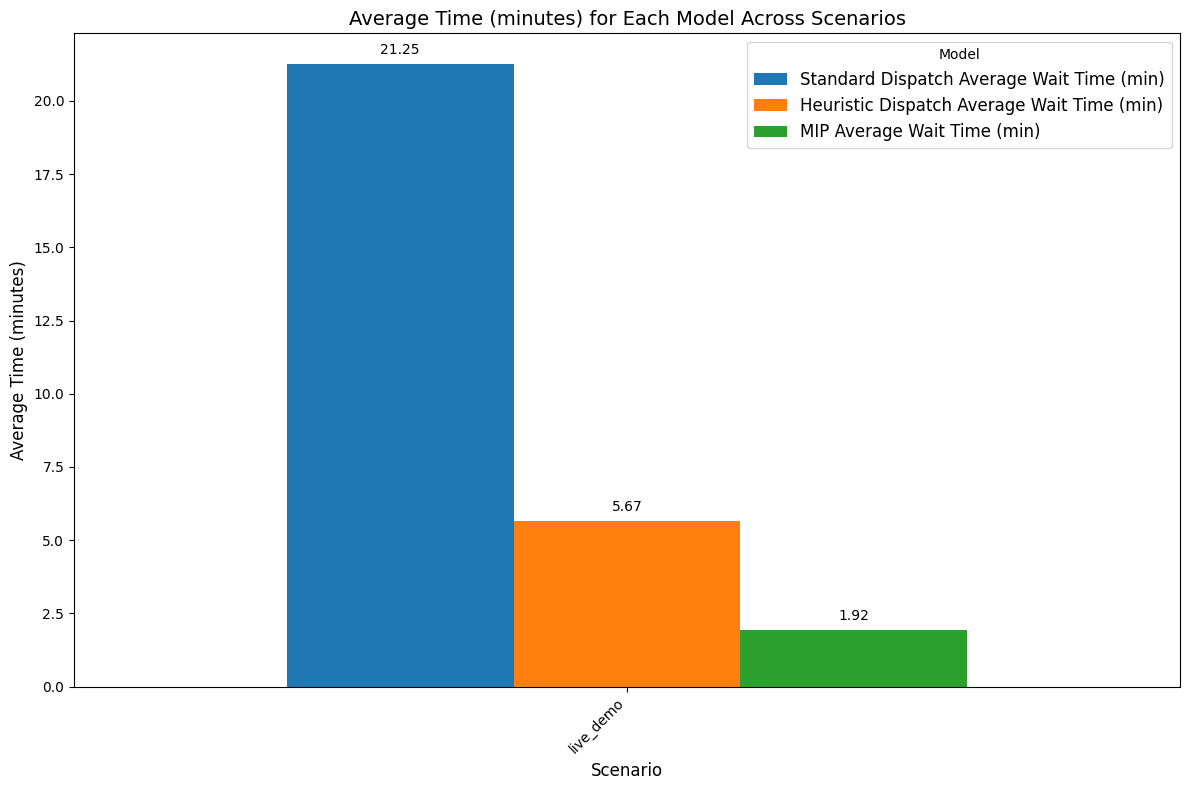

Execution times: [0.004865884780883789, 0.006338357925415039, 8.996217012405396]


In [18]:
import pandas as pd
import matplotlib.pyplot as plt


# Updated data with the correct MIP times
data = {
    "Scenario": ["live_demo"],
    "Standard Dispatch Average Wait Time (min)": [avg_wait_time[2]],
    "Heuristic Dispatch Average Wait Time (min)": [avg_wait_time[1]],
    "MIP Average Wait Time (min)": [avg_wait_time[0]],
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the scenario as the index for easy plotting
df.set_index("Scenario", inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting average times for all models
df.plot(kind='bar', width=0.8, ax=ax)

# Add labels above each bar
for container in ax.containers:
    ax.bar_label(container, labels=[f'{x.get_height():.2f}' for x in container], fontsize=10, padding=5, color="black")

# Labels and title
plt.title('Average Time (minutes) for Each Model Across Scenarios', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Average Time (minutes)', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Model", fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

print(f"Execution times: {exec_time}")